In [1]:
# Setting the environment variables

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number.

In [3]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [4]:
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [5]:
# Spark session with 14 GB driver memory
spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

In [6]:
# loading the dataset from the EC2 instance - 2019-Oct.csv
df = spark.read.csv('/home/ec2-user/inputdata/2019-Oct.csv', header=True, inferSchema=True)

In [7]:
# exploring the dataframe - top 20 rows

df.head(20)

[Row(event_time='2019-10-01 00:00:00 UTC', event_type='view', product_id=44600062, category_id=2103807459595387724, category_code=None, brand='shiseido', price=35.79, user_id=541312140, user_session='72d76fde-8bb3-4e00-8c23-a032dfed738c'),
 Row(event_time='2019-10-01 00:00:00 UTC', event_type='view', product_id=3900821, category_id=2053013552326770905, category_code='appliances.environment.water_heater', brand='aqua', price=33.2, user_id=554748717, user_session='9333dfbd-b87a-4708-9857-6336556b0fcc'),
 Row(event_time='2019-10-01 00:00:01 UTC', event_type='view', product_id=17200506, category_id=2053013559792632471, category_code='furniture.living_room.sofa', brand=None, price=543.1, user_id=519107250, user_session='566511c2-e2e3-422b-b695-cf8e6e792ca8'),
 Row(event_time='2019-10-01 00:00:01 UTC', event_type='view', product_id=1307067, category_id=2053013558920217191, category_code='computers.notebook', brand='lenovo', price=251.74, user_id=550050854, user_session='7c90fc70-0e80-4590-96

In [8]:
# exploring the dataframe - schema

df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [9]:
# Number of rows and columns in the dataset

df.count()

42448764

So, we have a huge dataset that contains 42 million rows.

Now, tha dataset is loaded in Spark environment. Let's proceed with the desired tasks.

<hr>

## Task 1 - Data Exploration

**Find**
- 5 most popular:
    - Products sold by the e-commerce company in the month
    - Brands on the platform
    - Product categories
- Number of unique users and the most active user on the platform
- Average and maximum price for smartphones purchased by the customers
<br>

**Plot and comment**
- Event-type funnel distribution in e-commerce shopping journey
- Traffic on different days of the week

Provide the results in a separate report.

In [10]:
# 5 most popular products sold

from pyspark.sql.functions import col

df.groupBy('product_id').count().sort(col('count').desc()).show(5)

+----------+------+
|product_id| count|
+----------+------+
|   1004856|500354|
|   1004767|438232|
|   1005115|355786|
|   1004833|237545|
|   1004249|231070|
+----------+------+
only showing top 5 rows



In [11]:
# 5 most popular brands

df.groupBy('brand').count().sort(col('count').desc()).show(6)

+-------+-------+
|  brand|  count|
+-------+-------+
|   null|6113008|
|samsung|5282775|
|  apple|4122554|
| xiaomi|3083763|
| huawei|1111205|
|lucente| 655861|
+-------+-------+
only showing top 6 rows



In [10]:
# 5 most popular product categories

from pyspark.sql.functions import col

df.groupBy('category_code').count().sort(col('count').desc()).show(6,False)

+---------------------------+--------+
|category_code              |count   |
+---------------------------+--------+
|null                       |13515609|
|electronics.smartphone     |11507231|
|electronics.clocks         |1311033 |
|computers.notebook         |1137623 |
|electronics.video.tv       |1113750 |
|electronics.audio.headphone|1100188 |
+---------------------------+--------+
only showing top 6 rows



In [12]:
# Number of unique users
from pyspark.sql.functions import countDistinct

df.select(countDistinct('user_id')).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                3022290|
+-----------------------+



In [13]:
# The most active user on the platform

df.groupBy('user_id').count().sort(col('count').desc()).show()

+---------+-----+
|  user_id|count|
+---------+-----+
|512475445| 7436|
|512365995| 4013|
|526731152| 2912|
|512505687| 2894|
|513021392| 2862|
|546159478| 2433|
|546270188| 2426|
|514649263| 2390|
|516308435| 2316|
|512401084| 2232|
|551211823| 2198|
|537873067| 2187|
|512786243| 2178|
|532769022| 2165|
|559249905| 2071|
|512792872| 1982|
|513828022| 1979|
|563459593| 1950|
|522244661| 1913|
|515240336| 1897|
+---------+-----+
only showing top 20 rows



In [14]:
# Average and Maximum price for smartphones purchased by the customers

from pyspark.sql.functions import max as maxval
from pyspark.sql.functions import mean as avgval

df.groupBy('category_code').agg(maxval("price")).where(col('category_code') == 'electronics.smartphone').show(50,truncate=False)

+----------------------+----------+
|category_code         |max(price)|
+----------------------+----------+
|electronics.smartphone|2110.45   |
+----------------------+----------+



In [15]:
df.groupBy('category_code').agg(avgval("price")).where(col('category_code') == 'electronics.smartphone').show(50,truncate=False)

+----------------------+-----------------+
|category_code         |avg(price)       |
+----------------------+-----------------+
|electronics.smartphone|471.9470821347332|
+----------------------+-----------------+



<Figure size 2160x1440 with 0 Axes>

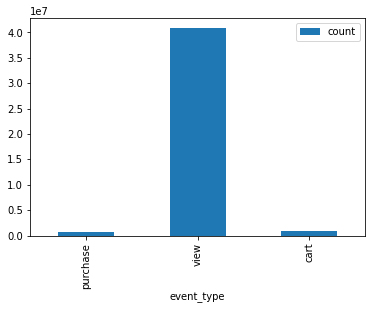

In [16]:
# Event-type funnel distribution
# Remember Spark dataframe cannot be visualised directly

import matplotlib.pyplot as plt

funnel_data = df.select('event_type').groupBy('event_type').count().toPandas()

plt.figure(figsize=(30,20))
funnel_data.plot(x = 'event_type', y = 'count', kind='bar')

plt.show()

In [17]:
from pyspark.sql.functions import to_timestamp,dayofweek,hour

df = df.withColumn('event_timestamp', to_timestamp('event_time', 'yyyy-MM-dd HH:mm:ss'))

In [18]:
df = df.withColumn('event_day', dayofweek(df['event_timestamp']))

day_traffic_df = df.select('event_day').groupBy('event_day').count().orderBy('event_day').toPandas()

<Figure size 2160x1440 with 0 Axes>

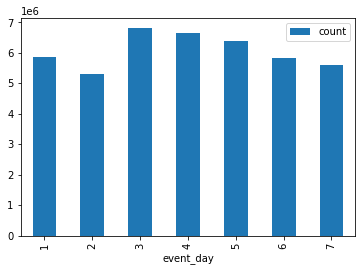

In [19]:
# Traffic on different days of the week
# Remember Spark dataframe cannot be visualised directly

plt.figure(figsize=(30,20))
day_traffic_df.plot(x = 'event_day', y = 'count', kind='bar')

plt.show()

In [20]:
# drop redundant column(s), if any

df = df.drop('event_time')

<hr>

## Task 2 - Feature Engineering

- Handle missing values (provide justification for approach)
- Generate the category code at 2 levels (Split into 2 columns)
    - Example: electronics.video.tv - electronics, video
- Capture user activity in different columns
    - Total activities (view/cart/etc.) in the session
    - Affinity towards a particular product (Product count for user)
    - Affinity towards a category (Secondary category count for user)
    - Average shopping expense for a product category (secondary)
    - Number of user sessions
- Impact of time: Day and Hour (Binning hours into 4 buckets)
- Reduction in brands for analysis: Top 20 + ‘others’
- Target variable generation: is_purchased


In [21]:
# Handling missing values 

from pyspark.sql.functions import isnull,when,count
df.select([count(when(isnull(cols), cols)) for cols in df.columns]).show()

+---------------------------------------------------------+---------------------------------------------------------+-----------------------------------------------------------+---------------------------------------------------------------+-----------------------------------------------+-----------------------------------------------+---------------------------------------------------+-------------------------------------------------------------+-------------------------------------------------------------------+-------------------------------------------------------+
|count(CASE WHEN (event_type IS NULL) THEN event_type END)|count(CASE WHEN (product_id IS NULL) THEN product_id END)|count(CASE WHEN (category_id IS NULL) THEN category_id END)|count(CASE WHEN (category_code IS NULL) THEN category_code END)|count(CASE WHEN (brand IS NULL) THEN brand END)|count(CASE WHEN (price IS NULL) THEN price END)|count(CASE WHEN (user_id IS NULL) THEN user_id END)|count(CASE WHEN (user_session IS NU

In [22]:
df = df.na.drop()

Reason for the action performed:



In [23]:
# Checking for duplicate entries

df.distinct().count()

26534109

In [24]:
# Take required action here

df = df.dropDuplicates()

In [25]:
# drop redundant column(s), if any

df = df.drop('category_id')

In [26]:
# Generating 2 columns from category code
# Columns have only single entity (electronics.video.tv: electronics, video)
# Check if split command works with '.' or Spark treats it as special character

from pyspark.sql.functions import split
df = df.withColumn('main_categ', split(col('category_code'), "\.").getItem(0)).withColumn('sub_categ', split(col('category_code'), "\.").getItem(1))

In [27]:
# Check if the column is added

df.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- event_day: integer (nullable = true)
 |-- main_categ: string (nullable = true)
 |-- sub_categ: string (nullable = true)



In [28]:
# Activities in a session by the user
# Window functions can be helpful here

import pyspark.sql.functions as F
from pyspark.sql import Window

df = df.withColumn('user_session_activity', F.count('user_session').over(Window.partitionBy('user_session')))

In [29]:
# View count for a product by the user
# Window functions can be helpful here

df = df.withColumn('user_product_count', F.count('user_id').over(Window.partitionBy('user_id','product_id')))

In [30]:
# View count for the secondary category by the user
# Window functions can be helpful here

df = df.withColumn('sub_categ_user_count', F.count('user_id').over(Window.partitionBy('user_id','sub_categ')))

In [31]:
# Average shopping expense for a product category
# Window functions can be helpful here

df = df.withColumn('prod_avg_spend', F.avg('price').over(Window.partitionBy('user_id','sub_categ')))

In [32]:
# Session count for a user
# Window functions can be helpful here

df = df.withColumn('user_sess_count', F.approx_count_distinct('user_session').over(Window.partitionBy('user_id')))

In [33]:
# Generating the hour variable

from pyspark.sql.functions import hour
df = df.withColumn('hour', hour(df['event_timestamp']))

In [34]:
# Reduction in brands for analysis: Top 20 + ‘others'

top_brand_df = df.groupBy('brand').count().orderBy('count',ascending=False).toPandas()
top_brand_list = list(top_brand_df['brand'][20:])
df = df.replace(top_brand_list, 'others', subset=['brand'])
df.groupBy('brand').count().orderBy('count',ascending=False).show(21)

+--------+-------+
|   brand|  count|
+--------+-------+
|  others|8880932|
| samsung|5147344|
|   apple|4087084|
|  xiaomi|2695456|
|  huawei|1090907|
|      lg| 508504|
|    oppo| 482131|
|    acer| 427810|
|  lenovo| 337854|
|   bosch| 329665|
|      hp| 294927|
| indesit| 289681|
| respect| 255502|
|   casio| 253547|
|   artel| 237098|
|    sony| 221161|
|elenberg| 217987|
|    asus| 211622|
|    beko| 206664|
|   haier| 180166|
| pioneer| 178067|
+--------+-------+



In [35]:
# Generating 'is_purchased' variable

df = df.withColumn('is_purchased', F.when(df['event_type']=='purchase',1).otherwise(0))

df = df.withColumn("label", F.max("is_purchased").over(Window.partitionBy('user_id','product_id')))

In [36]:
# Dropping redundant rows

df = df.filter(df.event_type=='cart')

In [37]:
# Printing the top 20 rows as output

df.show(20)

+----------+----------+--------------------+--------+-------+---------+--------------------+-------------------+---------+-----------+----------+---------------------+------------------+--------------------+------------------+---------------+----+------------+-----+
|event_type|product_id|       category_code|   brand|  price|  user_id|        user_session|    event_timestamp|event_day| main_categ| sub_categ|user_session_activity|user_product_count|sub_categ_user_count|    prod_avg_spend|user_sess_count|hour|is_purchased|label|
+----------+----------+--------------------+--------+-------+---------+--------------------+-------------------+---------+-----------+----------+---------------------+------------------+--------------------+------------------+---------------+----+------------+-----+
|      cart|   1004870|electronics.smart...| samsung| 283.62|454388908|a45905b4-f628-4df...|2019-10-22 10:26:12|        3|electronics|smartphone|                    2|                 2|             

In [38]:
# Dropping the redundant columns 

df = df.drop('event_type', 'product_id', 'category_code', 'user_id', 'user_session', 'event_timestamp', 'main_categ',\
             'hour', 'is_purchased')

In [39]:
# Columns in df after feature engineering

df.columns

['brand',
 'price',
 'event_day',
 'sub_categ',
 'user_session_activity',
 'user_product_count',
 'sub_categ_user_count',
 'prod_avg_spend',
 'user_sess_count',
 'label']

In [40]:
df.printSchema()

root
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- event_day: integer (nullable = true)
 |-- sub_categ: string (nullable = true)
 |-- user_session_activity: long (nullable = false)
 |-- user_product_count: long (nullable = false)
 |-- sub_categ_user_count: long (nullable = false)
 |-- prod_avg_spend: double (nullable = true)
 |-- user_sess_count: long (nullable = false)
 |-- label: integer (nullable = true)



In [41]:
# Storing the cleaned df in the instance to prevent repetition of steps again
# Rename the file based on your preferences
df.coalesce(1).write.option("header", "true").parquet("cleaned_df.parquet")

Proceed to another notebooks after saving the dataframe.